In [ ]:
# All the imports come here
import os
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

In [ ]:
# It's important to comment the import depending on the OS
# Windows PC
# base_dir = r"/dataset/car parts"

# Mac OS
# base_dir = "/Users/alanpagzz/Codes/carssification_AI/dataset/car parts"

# Google Colab
from google.colab import drive
drive.mount('/content/drive')
drive_dataset_path = "/content/drive/MyDrive/Octavo Semestre/IA/proyecto/car dataset/car parts"

# New local route
local_dataset_path = "/content/car_parts"\

# Copy the dataset to the local machine (just once)
if not os.path.exists(local_dataset_path):
  shutil.copytree(drive_dataset_path, local_dataset_path)

Mounted at /content/drive


In [ ]:
train_dir = os.path.join(drive_dataset_path , "train")
valid_dir = os.path.join(drive_dataset_path , "valid")
test_dir = os.path.join(drive_dataset_path , "test")

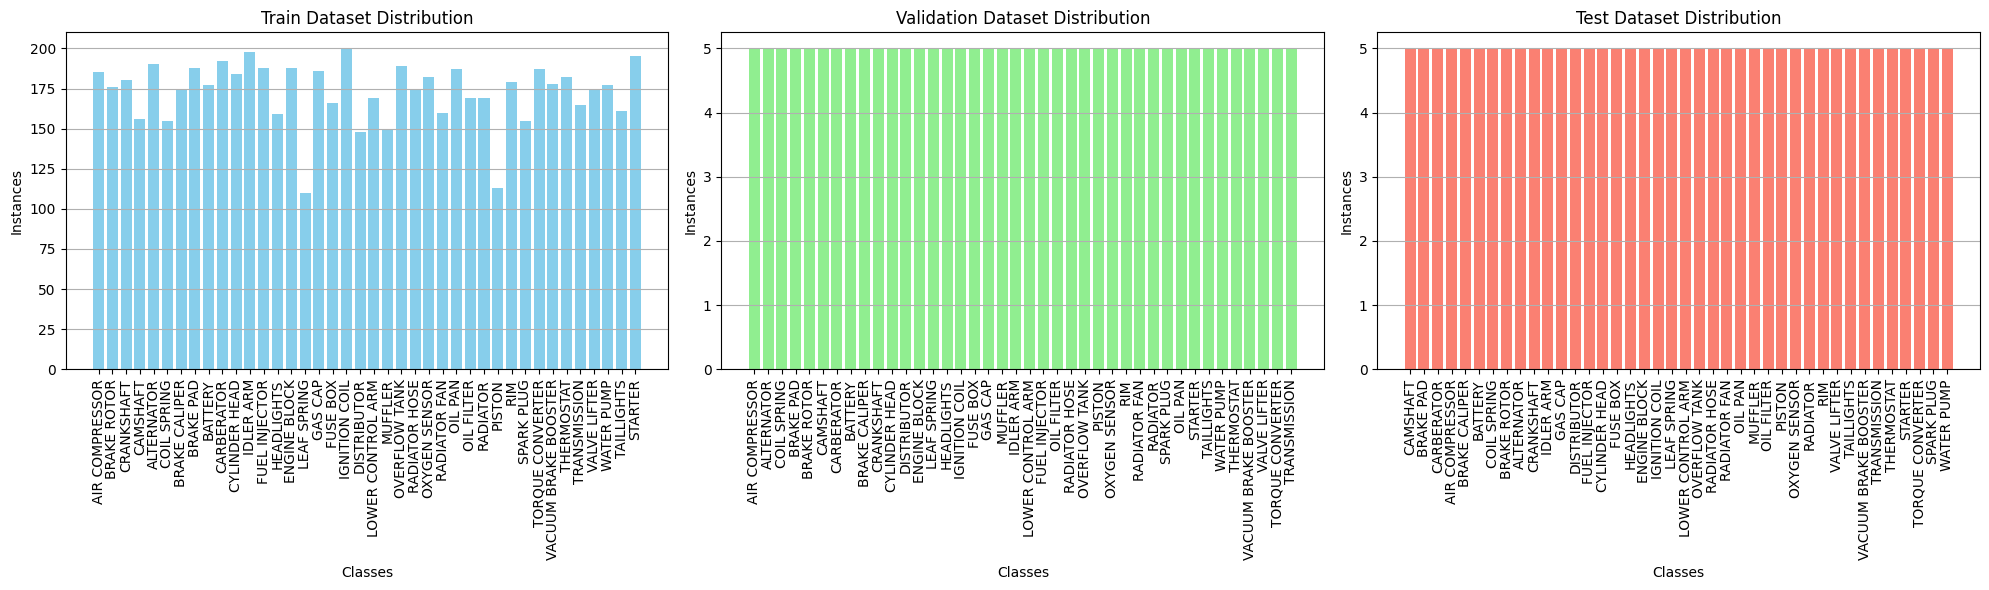

In [ ]:
# count images in each directory
def count_images_in_directory(dataset_path):
    class_counts = {}
    for class_name in os.listdir(dataset_path):
        class_folder = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_folder):
            num_images = len(os.listdir(class_folder))
            class_counts[class_name] = num_images
    return class_counts

train_counts = count_images_in_directory(train_dir)
valid_counts = count_images_in_directory(valid_dir)
test_counts = count_images_in_directory(test_dir)

# convert dictionary to DataFrame for better visualization
train_distribution = pd.DataFrame(list(train_counts.items()), columns=['Class', 'Count'])
valid_distribution = pd.DataFrame(list(valid_counts.items()), columns=['Class', 'Count'])
test_distribution = pd.DataFrame(list(test_counts.items()), columns=['Class', 'Count'])

plt.figure(figsize=(20, 6))

# Train
plt.subplot(1, 3, 1)
plt.bar(train_distribution['Class'], train_distribution['Count'], color='skyblue')
plt.xticks(rotation=90)
plt.title('Train Dataset Distribution')
plt.xlabel('Classes')
plt.ylabel('Instances')
plt.grid(axis='y')

# Val
plt.subplot(1, 3, 2)
plt.bar(valid_distribution['Class'], valid_distribution['Count'], color='lightgreen')
plt.xticks(rotation=90)
plt.title('Validation Dataset Distribution')
plt.xlabel('Classes')
plt.ylabel('Instances')
plt.grid(axis='y')

# Test
plt.subplot(1, 3, 3)
plt.bar(test_distribution['Class'], test_distribution['Count'], color='salmon')
plt.xticks(rotation=90)
plt.title('Test Dataset Distribution')
plt.xlabel('Classes')
plt.ylabel('Instances')
plt.grid(axis='y')

plt.tight_layout()
plt.show()


In [ ]:
# Time to preprocess the data
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range = 10,
    width_shift_range = 0.2,
	  height_shift_range = 0.2,
    #shear_range = 0.3,
	  #zoom_range = 0.3,
	  horizontal_flip = True
    )

valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range = 10,
    width_shift_range = 0.2,
	  height_shift_range = 0.2,
    #shear_range = 0.3,
	  #zoom_range = 0.3,
	  horizontal_flip = True
        )

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
        )


train_generator = train_datagen.flow_from_directory(
    train_dir,
    # My images are 254x254
    target_size=(254, 254),
    batch_size=16,
    class_mode="categorical"
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(254, 254),
    batch_size=16,
    class_mode="categorical",
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(254, 254),
    batch_size=16,
    class_mode="categorical",
    shuffle=False
)


Found 6917 images belonging to 40 classes.
Found 200 images belonging to 40 classes.
Found 200 images belonging to 40 classes.


In [ ]:
# ResNet50
# Retrieved from documentation

with tf.device('/GPU:0'):
      ResNet50 = tf.keras.applications.ResNet50(
        input_shape=(254, 254, 3),
        include_top=False,
        weights="imagenet",
        classifier_activation="softmax",
        name="resnet50"
      )

      ResNet50.trainable = False

  # This is my model
      model = tf.keras.models.Sequential([
        ResNet50,
        Dropout(0.3),
        GlobalAveragePooling2D(),
        Dense(512, activation = 'relu'),
        Dropout(0.3),
        Dense(256, activation = 'relu'),
        Dense(128, activation = 'relu'),
        Dropout(0.2),
        Dense(40, activation = 'softmax')
  ])

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 40)             │         5,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,806,184 (94.63 MB)

 Trainable params: 1,218,472 (4.65 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Time to add a checkpoint

# I want it on the same spot on every device, It's easier

# Drive
checkpoint_path = "/content/drive/MyDrive/Octavo Semestre/IA/proyecto/checkpoints/final-cp-{epoch:02d}.keras"

# Windows and Mac OS
# checkpoint_path = os.path.join(r"./", "checkpoints", "final-nodrops-cp-{epoch:02d}.keras")

# Callback to save the best model
checkpoint_cb = ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

# Callback to stop if tehre's no improvement in 5 epochs
earlystop_cb = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Test dir callback
test_accuracy = []
test_loss = []

def evaluate_model(epoch, logs):
    loss, acc = model.evaluate(test_generator, verbose=0)
    test_accuracy.append(acc)
    test_loss.append(loss)
    print(f"Epoch {epoch + 1}: Test accuracy: {acc:.4f}, Test loss: {loss:.4f}")

test_cb = tf.keras.callbacks.LambdaCallback(on_epoch_end=evaluate_model)


In [ ]:
def compile_model_simple(model):
    # CATEGORICAL CROSS SENTROPY
    model.compile(optimizer= "adam", loss = "categorical_crossentropy", metrics=['accuracy'])

def train_model_simple(model, scaled_train_images):
  # The cancer model paper mentions that it reaches a good level of accuracy on
  # epoch 20ish (The graph is up to epoch 25)
    history = model.fit(scaled_train_images,
                        validation_data=valid_generator,
                        epochs = 25,
                        callbacks=[checkpoint_cb, earlystop_cb, test_cb])
    return history

In [ ]:
compile_model_simple(model)
history = train_model_simple(model, train_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.5350 - loss: 1.7266
Epoch 1: val_accuracy improved from -inf to 0.79500, saving model to /content/drive/MyDrive/Octavo Semestre/IA/proyecto/checkpoints/final-cp-01.keras
Epoch 1: Test accuracy: 0.8250, Test loss: 0.5614
433/433 ━━━━━━━━━━━━━━━━━━━━ 188s 399ms/step - accuracy: 0.5354 - loss: 1.7250 - val_accuracy: 0.7950 - val_loss: 0.6993
Epoch 2/25
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.8528 - loss: 0.4770
Epoch 2: val_accuracy improved from 0.79500 to 0.83500, saving model to /content/drive/MyDrive/Octavo Semestre/IA/proyecto/checkpoints/final-cp-02.keras
Epoch 2: Test accuracy: 0.8450, Test loss: 0.5724
433/433 ━━━━━━━━━━━━━━━━━━━━ 160s 370ms/step - accuracy: 0.8528 - loss: 0.4770 - val_accuracy: 0.8350 - val_loss: 0.6751
Epoch 3/25
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.8871 - loss: 0.3426
Epoch 3: val_accuracy improved from 0.83500 to 0.89500, saving model to /content/drive/MyDr

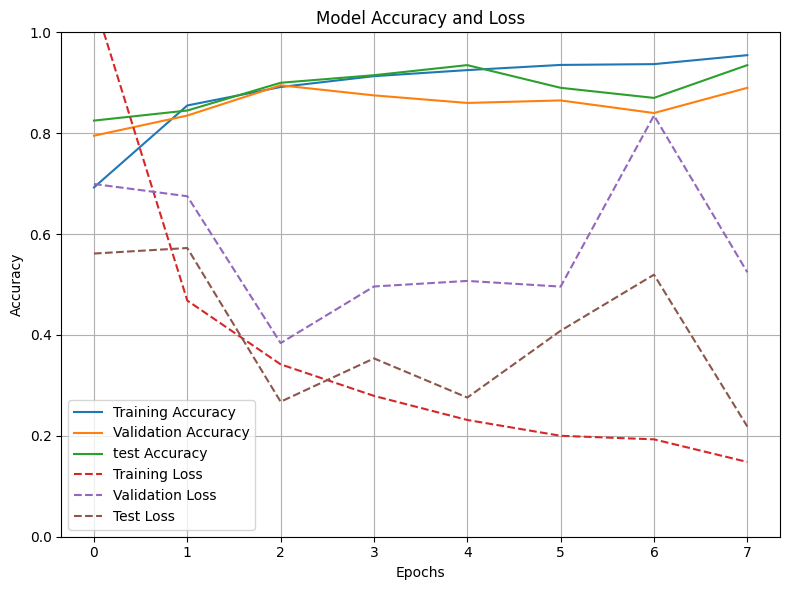

In [ ]:
# Join all plots in one plot

def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(test_accuracy, label='test Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(history.history['loss'], label='Training Loss', linestyle='--')
    plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
    plt.plot(test_loss, label='Test Loss', linestyle='--')
    plt.title('Model Accuracy and Loss')
    plt.xlabel('Epochs')
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [ ]:
# Getting results
true_classes = test_generator.classes
test_generator.reset()

# Get model predictions on validation data
test_pred_probs = model.predict(test_generator, verbose=1)

# Get predicted classes
test_pred_classes = np.argmax(test_pred_probs, axis=1)

# Get true classes from generator
num_classes = len(test_generator.class_indices)

conf_matrix = np.zeros((num_classes, num_classes), dtype=int)

for i in range(len(true_classes)):
    actual = true_classes[i]
    pred = test_pred_classes[i]
    conf_matrix[actual][pred] += 1


13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 399ms/step


In [ ]:
precisions = []
recalls = []
f1s = []

for i in range(num_classes):
    TP = conf_matrix[i][i]
    FP = np.sum(conf_matrix[:, i]) - TP
    FN = np.sum(conf_matrix[i, :]) - TP
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

# Averages
macro_precision = np.mean(precisions)
macro_recall = np.mean(recalls)
macro_f1 = np.mean(f1s)

print(f"precision: {macro_precision:.4f}, recall: {macro_recall:.4f}, f1: {macro_f1:.4f}")

precision: 0.9273, recall: 0.9000, f1: 0.8929


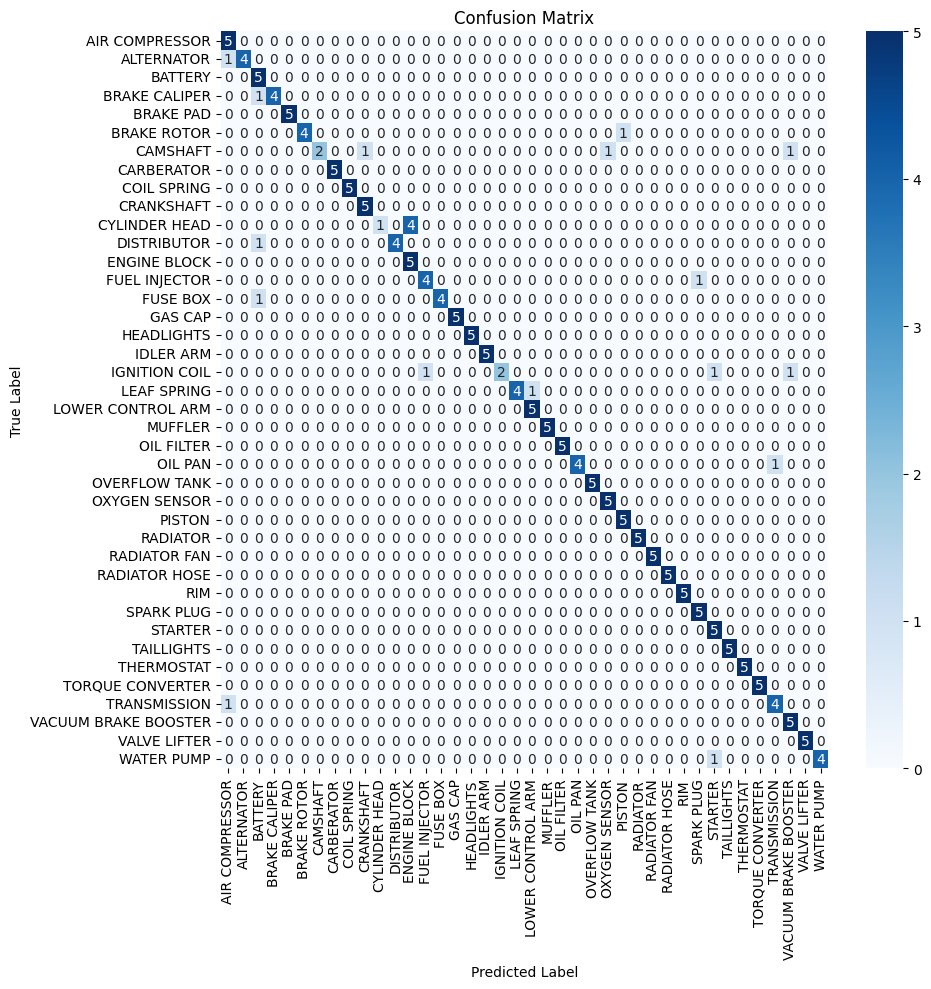

In [ ]:
# printing the confusion matrix
class_names = list(test_generator.class_indices.keys())
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()